# E and C index from Takahashi et al. 2011

<div style="
    max-width: 500px; 
    padding: 10px; 
    background-color: rgba(240, 240, 240, 0.85); 
    color: black; 
    border-radius: 5px;
    border: 1px solid rgba(0, 0, 0, 0.1);
">
    <strong>Takahashi, K., Montecinos, A., Goubanova, K., and Dewitte, B (2011)</strong>, 
    ENSO regimes: Reinterpreting the canonical and Modoki El Niño, 
    <i>Geophys. Res. Lett.</i>, 38, L10704, 
    <a href="https://doi.org/10.1029/2011GL047364" style="color: #1a73e8;">doi:10.1029/2011GL047364</a>.
</div>

The paper developed by Takahashi et al. proposes that the first two modes resulting from the Empirical Orthogonal Function (EOF) analysis of sea surface temperature anomalies do not represent distinct phenomena—EOF1 associated with El Niño-Southern Oscillation (ENSO) and EOF2 associated with El Niño Modoki—but rather the nonlinear evolution of ENSO. This evolution translates into the E and C indices, which are uncorrelated (not related by construction) and successfully explain the variability in the equatorial Pacific. The C index represents the variability regime in the central Pacific, while the E index corresponds to the eastern Pacific.  

The original study utilizes the Hadley Centre Global Sea Ice and Sea Surface Temperature (HadISST) version 1.1 dataset. The monitoring work conducted by IGP includes the calculation of this index using ERSSTv5, which can be accessed through the following [link](http://met.igp.gob.pe/variabclim/indices.html).  

To perform the calculations, we will use sea surface temperature data from ERSSTv5 [1], accessed via the OPENDAP server at NOAA. The following steps will be followed:  

<ol>  
<li>Load the data using xarray, adjusting the time axis if necessary, and restricting our domain to 10°S–10°N, 110°E–90°W, from January 1870 onward.</li>  

<li>Compute the anomalies using the 1979–2009 period as the baseline. This period will be used for all calculations (EOFs and correlations).</li>  

<li>Perform the EOF calculation over the climatological period.</li>  

<li>Project the complete anomaly time series onto the EOFs computed from the climatology to obtain the principal components (PCs). This is achieved via an inner product.</li>  

<li>Normalize the principal components using the standard deviation of the baseline period.</li>  

</ol>  

## References:  

[1]: Huang, B., P. W. Thorne, V. F. Banzon, T. Boyer, G. Chepurin, J. H. Lawrimore, M. J. Menne, T. M. Smith, R. S. Vose, and H.-M. Zhang, 2017: Extended Reconstructed Sea Surface Temperature, version 5 (ERSSTv5): Upgrades, validations, and intercomparisons. J. Climate, 30, 8179-8205, doi:10.1175/JCLI-D-16-0836.1.  

## Python code

First we need to import the necessary libraries and set the plotting style. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import xarray as xr
from xeofs.single import EOF

plt.rcParams["font.family"] = "monospace"

Most of the functions here have been defined to ease the process of calculating the indices. 

In [13]:
def compute_alpha(pc1, pc2):
    coefs = poly.polyfit(pc1, pc2, deg=2)
    xfit = np.arange(pc1.min(), pc1.max() + 0.1, 0.1)
    fit = poly.polyval(xfit, coefs)
    return coefs[-1], xfit, fit


def correction_factor(model):
    # EOF analysis is an eigenvalue problem, and the sign of the EOFs is arbitrary.
    # To ensure a consistent sign convention, we define a correction factor
    # based on the mean value of the EOFs in a specific region of the tropical Pacific.
    _eofs = model.components()
    _subset = dict(lat=slice(-5, 5), lon=slice(140, 180))
    corr_factor = np.zeros(2)
    corr_factor[0] = 1 if _eofs.sel(mode=1, **_subset).mean() > 0 else -1
    corr_factor[1] = 1 if _eofs.sel(mode=2, **_subset).mean() > 0 else -1
    return xr.DataArray(corr_factor, coords=[("mode", [1, 2])])


def compute_index(tos_anom, base_period):
    # select the tropical Pacific region
    tos_anom = tos_anom.sel(lat=slice(-20, 20), lon=slice(100, 280))

    model = EOF(n_modes=2, use_coslat=True)

    # Compute Eofs with the base period
    model.fit(tos_anom.sel(time=slice(*base_period)), dim="time")
    scale_factor = 1 / np.sqrt(model.explained_variance())

    # Compute the correction factor
    corr_factor = correction_factor(model)

    # Project the complete series of anomalies onto the climatological EOFs
    # we apply the scale factor and the correction factor
    pcs = model.transform(tos_anom) * scale_factor * corr_factor

    pc1 = pcs.sel(mode=1)
    pc2 = pcs.sel(mode=2)

    # Perform 45-degree rotation to obtain the E and C indices
    eindex = (pc1 - pc2) / (2 ** (1 / 2))
    eindex.name = "E_index"
    cindex = (pc1 + pc2) / (2 ** (1 / 2))
    cindex.name = "C_index"
    ecindex = xr.merge([eindex, cindex])

    # Select only the winter months (December, January, February)
    # to compute alpha fit
    pc1_djf = pc1.sel(time=pc1.time.dt.month.isin([12, 1, 2]))
    pc1_djf = (
        pc1_djf.resample(time="QS-DEC")
        .mean()
        .dropna("time")
        .sel(time=slice("1980", None))
    )
    pc1_djf["time"] = (
        pc1_djf.indexes["time"].to_series().apply(lambda x: x + pd.DateOffset(years=1))
    )
    pc1_djf.name = "pc1_djf"

    pc2_djf = pc2.sel(time=pc2.time.dt.month.isin([12, 1, 2]))
    pc2_djf = (
        pc2_djf.resample(time="QS-DEC")
        .mean()
        .dropna("time")
        .sel(time=slice("1980", None))
    )
    pc2_djf["time"] = (
        pc2_djf.indexes["time"].to_series().apply(lambda x: x + pd.DateOffset(years=1))
    )
    pc2_djf.name = "pc2_djf"

    pcs_djf = xr.concat([pc1_djf, pc2_djf], dim="mode")

    alpha, xfit, fit = compute_alpha(pc1_djf, pc2_djf)

    return ecindex, pcs_djf, alpha, xfit, fit

## Data loading

We will use the ERSSTv5 dataset accessed via OPeNDAP. 

In [3]:
# do not decode time because we need to fix the calendar
ersstv5 = xr.open_dataset(
    "http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc",
).sortby("lat")
ersstv5

<xarray.Dataset> Size: 132MB
Dimensions:    (lat: 89, lon: 180, time: 2054, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 132MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2025-03-04
    DODS_EXTRA.Unlimited_Dimension:  time

## Data Processing

For this index we just need to define a base period from which the anomalies and climatological EOFs will be calculated.

In [4]:
sst = ersstv5.sst

base_period = ("1991", "2020")
sst_clim = sst.sel(time=slice(*base_period)).groupby("time.month").mean("time")
sst_anom = sst.groupby("time.month") - sst_clim

Sanity check

Text(0, 0.5, 'SST Anomaly (°C)')

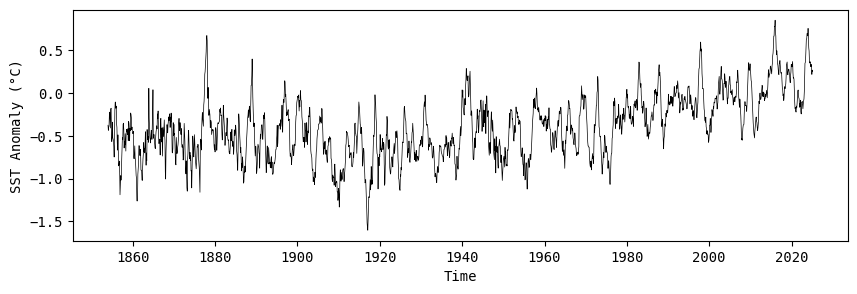

In [5]:
# Plot the tropical pacific mean
fig, ax = plt.subplots(figsize=(10, 3))
sst_anom.sel(lat=slice(-20, 20), lon=slice(100, 280)).mean(["lat", "lon"]).plot(
    ax=ax, c="k", lw=0.5
)
ax.set_ylabel("SST Anomaly (°C)")

Now we can pass our anomalies to the function that calculates the indices. This function has been setup to return the indices, the PCs for DJF and the quadratic fit (alpha value) for ENSO nonlinearity.

In [14]:
ecindex, pcs_djf, alpha, xfit, fit = compute_index(sst_anom, base_period=base_period)

### E and C indices plot

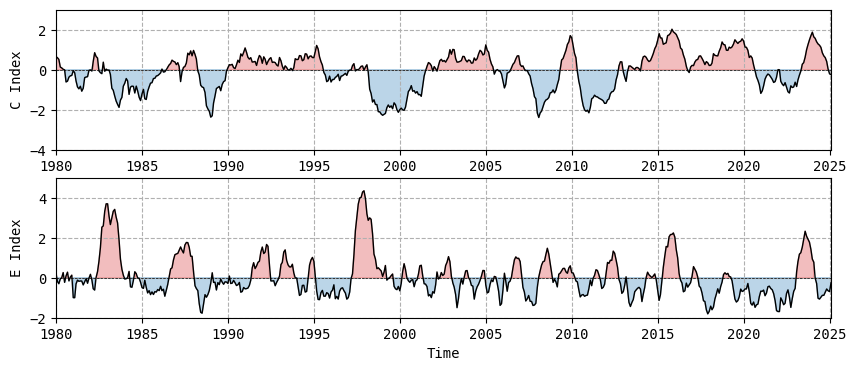

In [15]:
start_time = "1980"
e_sel = ecindex.E_index.sel(time=slice(start_time, None))
c_sel = ecindex.C_index.sel(time=slice(start_time, None))

shared_kwargs = dict(linewidth=1, linestyle="-", c="k")

fig, axs = plt.subplots(2, 1, figsize=(10, 4))
ax = axs[0]
c_sel.plot(ax=ax, **shared_kwargs)
ax.fill_between(
    c_sel.time, y1=0, y2=c_sel, where=(c_sel > 0), color="tab:red", alpha=0.3
)
ax.fill_between(
    c_sel.time, y1=0, y2=c_sel, where=(c_sel < 0), color="tab:blue", alpha=0.3
)
ax.set_ylabel("C Index")
ax.set_ylim(-4, 3)

ax = axs[1]
e_sel.plot(ax=ax, **shared_kwargs)
ax.fill_between(
    e_sel.time, y1=0, y2=e_sel, where=(e_sel > 0), color="tab:red", alpha=0.3
)
ax.fill_between(
    e_sel.time, y1=0, y2=e_sel, where=(e_sel < 0), color="tab:blue", alpha=0.3
)
ax.set_ylabel("E Index")
ax.set_ylim(-2, 5)

for ax in axs:
    ax.axhline(0, c="k", lw=0.5, ls="--")
    ax.set_xlabel("Time")
    ax.set_xlim(e_sel.time[0], e_sel.time[-1])
    ax.grid(ls="--")

## Alpha fit plot

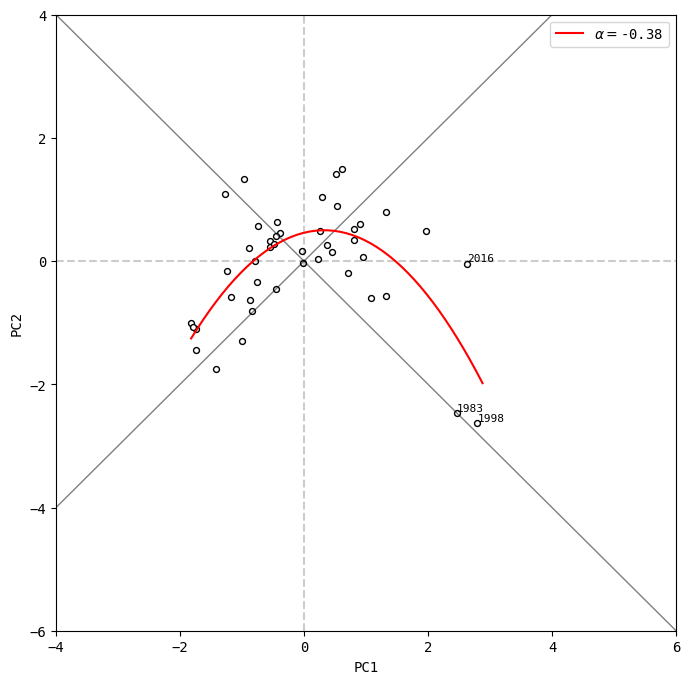

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.axhline(0, color="k", linestyle="--", alpha=0.2)
ax.axvline(0, color="k", linestyle="--", alpha=0.2)

# draw a line 45 degrees
x = np.linspace(-6, 6, 100)
y = x
ax.plot(x, y, color="k", alpha=0.5, lw=1)
ax.plot(-x, y, color="k", alpha=0.5, lw=1)

ax.scatter(
    pcs_djf.sel(mode=1),
    pcs_djf.sel(mode=2),
    s=18,
    marker="o",
    c="w",
    edgecolors="k",
    linewidths=1,
)

ax.plot(xfit, fit, c="r", label=f"$\\alpha=${alpha:.2f}")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

ax.set_xlim(-4, 6)
ax.set_ylim(-6, 4)
ax.legend()

_mask = np.logical_and(pcs_djf.sel(mode=1) > 2, pcs_djf.sel(mode=2) < 0)
for year in pcs_djf.sel(mode=1)[_mask].time.dt.year.data:
    ax.text(
        pcs_djf.sel(mode=1).sel(time=str(year).zfill(4)).values,
        pcs_djf.sel(mode=2).sel(time=str(year).zfill(4)).values,
        str(year),
        fontsize=8,
        ha="left",
        va="bottom",
        color="k",
    )